In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)

In [2]:
new_cols = ['year',
                   'weekofyear',
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',
                   'sj',
                   'iq']
new_norm = [
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',
]

In [3]:
(train_x, train_y), (test_x, test_y) = split_data(
    extract_data(train_file, CSV_COLUMNS), 
    label_column=LABEL_COLUMN,
    filter_cols=new_cols
)
train_x = preproc_data(train_x, norm_cols=new_norm)
test_x = preproc_data(test_x, norm_cols=new_norm)

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def preproc_data(data, norm_cols=cols_to_norm, scale_cols=cols_to_scale):
    # Make a copy, not to modify oryginal data
    new_data = data.copy()
    # Normalize temp and percipation
    new_data[norm_cols] = StandardScaler().fit_transform(new_data[norm_cols])

    # Scale year and week no but within (0,1)
    new_data[scale_cols] = MinMaxScaler(feature_range=(0, 1)).fit_transform(new_data[scale_cols])

    return new_data

train_x = preproc_data(train_x, norm_cols=new_norm)
train_x.head()

,year,weekofyear,reanalysis_tdtr_k,station_diur_temp_rng_c,precipitation_amt_mm,sj,iq
511,0.50,0.13,-0.83,-0.69,-0.91,1,0
961,0.50,0.96,2.26,1.94,-1.00,0,1
231,0.20,0.75,-0.65,-0.57,-1.08,1,0
687,0.65,0.54,-0.85,-1.04,0.46,1,0
34,0.00,0.98,-0.74,-1.06,-1.10,1,0


In [5]:
# Build network with 
def build_model(optimizer = None):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(len(train_x.keys()) * len(train_x.keys()), activation='relu', input_shape=[len(train_x.keys())]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  if not optimizer:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.9999, amsgrad=False)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


In [6]:
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# create model
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.01, nesterov=False, name='SGD')
model = build_model()

# Train the Model.
EPOCHS = 50

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5, min_lr=1e-6, verbose=1,
                                                     mode="max")

history = model.fit(
  train_x, train_y,
  epochs=EPOCHS, validation_data = (test_x, test_y), verbose=1,
                    callbacks=[tensorboard_callback, reduce_lr])

Train on 1165 samples, validate on 291 samples
Epoch 1/50
1165/1165 [==============================] - 1s 702us/sample - loss: 18.8200 - mae: 18.8200 - mse: 1898.2191 - val_loss: 17.8993 - val_mae: 17.8993 - val_mse: 2114.0559
Epoch 2/50
1165/1165 [==============================] - 0s 198us/sample - loss: 17.1853 - mae: 17.1853 - mse: 1746.7354 - val_loss: 17.0059 - val_mae: 17.0059 - val_mse: 2001.9791
Epoch 3/50
1165/1165 [==============================] - 0s 206us/sample - loss: 16.9021 - mae: 16.9021 - mse: 1679.0151 - val_loss: 17.0081 - val_mae: 17.0081 - val_mse: 1904.4974
Epoch 4/50
1165/1165 [==============================] - 0s 197us/sample - loss: 16.7768 - mae: 16.7768 - mse: 1672.8341 - val_loss: 16.8558 - val_mae: 16.8558 - val_mse: 1941.5455
Epoch 5/50
1165/1165 [==============================] - 0s 188us/sample - loss: 16.7941 - mae: 16.7941 - mse: 1663.7354 - val_loss: 16.8447 - val_mae: 16.8447 - val_mse: 2005.9019
Epoch 6/50
1024/1165 [=========================>....]

1165/1165 [==============================] - 0s 199us/sample - loss: 14.9138 - mae: 14.9138 - mse: 1513.8381 - val_loss: 16.2702 - val_mae: 16.2702 - val_mse: 1867.1971
Epoch 40/50
1165/1165 [==============================] - 0s 198us/sample - loss: 14.8864 - mae: 14.8864 - mse: 1500.8160 - val_loss: 16.2632 - val_mae: 16.2632 - val_mse: 1872.5814
Epoch 41/50
 992/1165 [========================>.....] - ETA: 0s - loss: 15.6356 - mae: 15.6356 - mse: 1700.8425
Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0016777213662862779.
1165/1165 [==============================] - 0s 206us/sample - loss: 14.8699 - mae: 14.8699 - mse: 1505.5031 - val_loss: 16.3257 - val_mae: 16.3257 - val_mse: 1878.5576
Epoch 42/50
1165/1165 [==============================] - 0s 206us/sample - loss: 14.8439 - mae: 14.8439 - mse: 1499.9510 - val_loss: 16.2753 - val_mae: 16.2753 - val_mse: 1894.1692
Epoch 43/50
1165/1165 [==============================] - 0s 203us/sample - loss: 14.8003 - mae: 14.8003 - m

In [73]:
org_test_data = preproc_data(extract_data(test_file, CSV_COLUMNS_NO_LABEL)[new_cols], norm_cols=new_norm)
org_test_data.head()
test_predictions = model.predict(org_test_data).flatten()
export_test_to_csv(test_predictions)

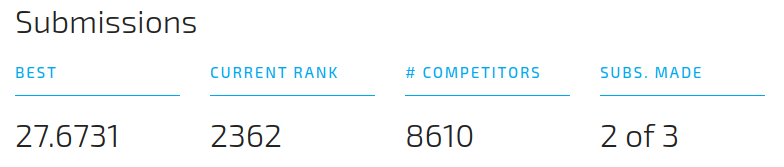

In [76]:
#Current Ranking (baseline)
Image("img/current-25-03.png")

In [77]:
# Tensorboard
# https://tensorboard.dev/experiment/rsdMubj0S165iOdLmbd13A/#scalars